In [1]:
import pandas as pd
import numpy as np
from random import shuffle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import yaml

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
with open("../config.yaml", 'r') as stream:
        key = (yaml.safe_load(stream))
        API_KEY = key['key']

In [5]:
df = pd.read_csv("../data/train-csv/subplot.csv")
df1 = pd.read_csv("../data/train-csv/subplot2.csv")
df = df.append(df1, ignore_index = True)
df = df.drop('IMAGERY_TITLE', axis = 1)
df = df.dropna(axis = 0)

plot_ids = sorted(df['PLOT_ID'].unique())

In [6]:
def find_data_by_plot(plot_id):
    item = [i for i, x in enumerate(plot_ids) if x == plot_id]
    return item

def reconstruct_images(plot_id):
    subs = df[df['PLOT_ID'] == plot_id]
    rows = []
    lats = reversed(sorted(subs['LAT'].unique()))
    for i, val in enumerate(lats):
        subs_lat = subs[subs['LAT'] == val]
        subs_lat = subs_lat.sort_values('LON', axis = 0)
        rows.append(list(subs_lat['TREE']))
    return rows

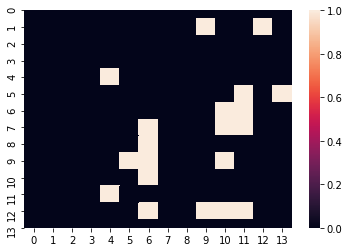

In [7]:
to_validate = reconstruct_images(135191138)
sns.heatmap(to_validate)

In [22]:
s1_old = [x for x in os.listdir("../data/train-s1/")]
s1_new = [x for x in os.listdir("../data/train-s1-new/")]
to_check = [x for x in s1_old if x in s1_new]

mean_diff = []
for i in to_check:
    old = np.load("../data/train-s1/{}".format(i))
    old = old[2, 2, 2, :]
    new = np.load("../data/train-s1-new/{}".format(i))
    new = new[2, 2, 2, :]
    mean_diff.append(np.sum(abs(old - new)))
print(np.mean(mean_diff))

0.10927076


## Test for blank time steps

In [48]:
def remove_blank_steps(array):
    to_update = {}
    sets = []
    for k in range(6):
        for i in range(array.shape[0]):
            for k in range(array.shape[-1]):
                mean = (np.mean(array[i, :, :, k]))
                if mean == 0:
                    sets.append(i)
                    if i < array.shape[0] - 1:
                        array[i, :, :, k] = array[i + 1, :, :, k]
                    else:
                        array[i, :, :, k] = array[i - 1, :, :, k]
                if mean == 1:
                    sets.append(i)
                    if i < array.shape[0] - 1:
                        array[i, :, :, k] = array[i + 1, :, :, k]
                    else:
                        array[i, :, :, k] = array[i - 1, :, :, k]
    for i in range(array.shape[0]):
        for k in range(array.shape[-1]):
            mean = (np.mean(array[i, :, :, k]))
            if mean == 0:
                if i < array.shape[0] - 2:
                    array[i, :, :, k] = array[i + 2, :, :, k]
                else:
                    array[i, :, :, k] = array[i - 2, :, :, k]
            if mean == 1:
                if i < array.shape[0] - 2:
                    array[i, :, :, k] = array[i + 2, :, :, k]
                else:
                    array[i, :, :, k] = array[i - 2, :, :, k]
    if set(sets):
        print(set(sets))
    return array

for i in range(0, 100):
    data = np.load('../data/processed/{}.npy'.format(str(i)))
    array = remove_blank_steps(data)

{6, 8, 9, 22, 23}
{1, 2, 19}
{10, 12, 13}
{3, 4, 21}


In [49]:
def plot_rgb_from_plot(plot_id):
    item = find_data_by_plot(plot_id)
    data = np.load("../data/processed/{}.npy".format(str(item[0])))
    #data = np.load("../data/processed/{}.npy".format(7))
    data = remove_blank_steps(data)
    data = data[5]
    #data = np.mean(data, axis = 0)
    data = data[:, :, [2, 1, 0]]
    #data = np.flip(data[:, :, 0:3], axis = 2)
    #print(data)
    plt.figure(figsize=(7, 7))
    plt.imshow(data)
    

In [50]:
df[df['PLOT_ID'] == df['PLOT_ID'].unique()[4]].head(5)

,PLOT_ID,SAMPLE_ID,LON,LAT,FLAGGED,ANALYSES,USER_ID,COLLECTION_TIME,ANALYSIS_DURATION,TREE
784,135191140,484052177,39.284649,13.857011,False,1,jo.m.brandt@gmail.com,2019-09-10 14:17:29.40725,138.6,0.0
785,135191140,484052178,39.284649,13.857098,False,1,jo.m.brandt@gmail.com,2019-09-10 14:17:29.40725,138.6,0.0
786,135191140,484052179,39.284649,13.857186,False,1,jo.m.brandt@gmail.com,2019-09-10 14:17:29.40725,138.6,0.0
787,135191140,484052180,39.284649,13.857273,False,1,jo.m.brandt@gmail.com,2019-09-10 14:17:29.40725,138.6,0.0
788,135191140,484052181,39.284649,13.857360,False,1,jo.m.brandt@gmail.com,2019-09-10 14:17:29.40725,138.6,0.0


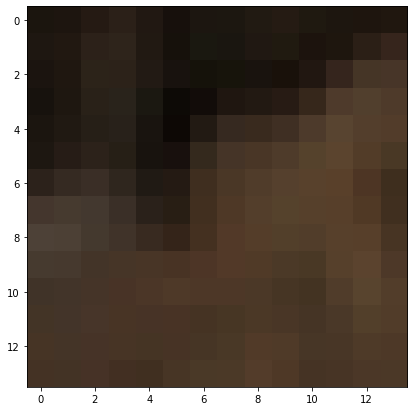

In [51]:
plot_rgb_from_plot(df['PLOT_ID'].unique()[4])

In [130]:
sample_id = int((len(df['PLOT_ID'].unique())*0.0) + 488/4)
sample_id

122

In [131]:
df['PLOT_ID'].unique()[sample_id]

135191283

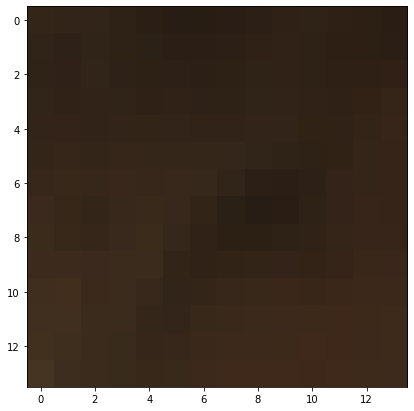

In [93]:
plot_rgb_from_plot(df['PLOT_ID'].unique()[sample_id])

In [ ]:
def ndvi(x):
    # (B8 - B4)/(B8 + B4)
    ndvis = [(im[:, :, 6] - im[:, :, 2]) / (im[:, :, 6] + im[:, :, 2]) for im in x]
    x_padding = np.zeros((x.shape[0], image_size, image_size, 1))
    x = np.concatenate((x, x_padding), axis = 3)
    # Iterate over each time step and add NDVI in as the 11th channel
    for i in range(x.shape[0]):
        x[i, :, :, 10] = ndvis[i]
    return x

In [96]:
(0.1 - 0.05) / (0.1 + 0.05)

0.3333333333333333

## Validate downloading

In [13]:
from sentinelhub import WcsRequest, WcsRequest, MimeType, CRS, BBox, constants
import datetime

EPSG = CRS.WGS84
location = ([38.180918605931225, 14.042459911560787],
            [38.182178703049935, 14.043683543556279])
API_KEY = key['key']


def download_tiles(bbox, epsg = EPSG, time = ('2017-01-01', '2017-12-31')):
    try:
        box = BBox(bbox, crs = epsg)
        image_request = WcsRequest(
                layer='TRUE_COLOR',
                bbox=box,
                time=time,
                image_format = MimeType.TIFF_d32f,
                maxcc=1,
                resx='10m', resy='10m',
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'BICUBIC'},
                time_difference=datetime.timedelta(hours=24),
            )
        img_bands = image_request.get_data()
        return img_bands, image_request

    except Exception as e:
        logging.fatal(e, exc_info=True)
        
x = download_tiles(location)

In [18]:
x[0][0].shape

(14, 14, 3)

In [19]:
location = [(38.18096474931849, 14.042505273551859),
            (38.18213255918785, 14.043638181775378)]
x = download_tiles(location)

In [20]:
x[0][0].shape

(13, 13, 3)